##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Mixture Density Networks with TFP

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/deep_exponential_family_with_tfp.ipynb"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/deep_exponential_family_with_tfp.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

Original content [this Repository](https://github.com/blei-lab/edward/blob/master/notebooks/mixture_density_network.ipynb) and [this tutorial](http://edwardlib.org/tutorials/mixture-density-network), created by [the Blei Lab](http://www.cs.columbia.edu/~blei/). Initial version of this tutorial written by Christopher Bonnett & David Ha.

Ported to [Tensorflow Probability](https://www.tensorflow.org/probability/) by Matthew McAteer ([`@MatthewMcAteer0`](https://twitter.com/MatthewMcAteer0)), with help from Bryan Seybold, Mike Shwe ([`@mikeshwe`](https://twitter.com/mikeshwe)), Josh Dillon, and the rest of the TFP team at  Google ([`tfprobability@tensorflow.org`](mailto:tfprobability@tensorflow.org)).

---

- Dependencies & Prerequisites
- Introduction
- Data
- Model
- Inference
- Criticism
- References

## Dependencies & Prerequisites

<div class="alert alert-success">
    Tensorflow Probability is part of the colab default runtime, <b>so you don't need to install Tensorflow or Tensorflow Probability if you're running this in the colab</b>. 
    <br>
    If you're running this notebook in Jupyter on your own machine (and you have already installed Tensorflow), you can use the following
    <br>
      <ul>
    <li> For the most recent nightly installation: <code>pip3 install -q tfp-nightly</code></li>
    <li> For the most recent stable TFP release: <code>pip3 install -q --upgrade tensorflow-probability</code></li>
    <li> For the most recent stable GPU-connected version of TFP: <code>pip3 install -q --upgrade tensorflow-probability-gpu</code></li>
    <li> For the most recent nightly GPU-connected version of TFP: <code>pip3 install -q tfp-nightly-gpu</code></li>
    </ul>
Again, if you are running this in a Colab, Tensorflow and TFP are already installed
</div>

In [0]:
#@title Imports and Global Variables  { display-mode: "form" }
!pip3 install -q observations
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import math
import numpy as np
import string
from datetime import datetime
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
  try:
    tf.enable_eager_execution()
  except:
    pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
  """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
  Args:
  tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
    `namedtuple` or combinations thereof.
 
  Returns:
    ndarrays: Object with same structure as `tensors` except with `Tensor` or
      `EagerTensor`s replaced by Numpy `ndarray`s.
  """
  if tf.executing_eagerly():
    return tf.contrib.framework.nest.pack_sequence_as(
        tensors,
        [t.numpy() if tf.contrib.framework.is_tensor(t) else t
         for t in tf.contrib.framework.nest.flatten(tensors)])
  return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()


# from edward.models import Categorical, Mixture, Normal
from scipy import stats
from sklearn.model_selection import train_test_split


## Introduction

Mixture density networks (MDN) (Bishop, 1994) are a class of models obtained by combining a conventional neural network with a mixture density model. They are incredibly usefu for solving inverse problems. Before we go into how to use them, let's see what we might attempt in the absence of a model like this.


To get started, let’s try to quickly build a neural network to fit some fake data. As neural nets of even one hidden layer can be universal function approximators, we can see if we can train a simple neural network to fit a noisy sinusoidal data, like this (  $\epsilon$ is just standard gaussian random noise):
$$
y = 7.0 \text{ sin}(0.75x) + 0.5x + \epsilon
$$

Size of features in x data: (5000, 1)
Size of output in y data: (5000, 1)


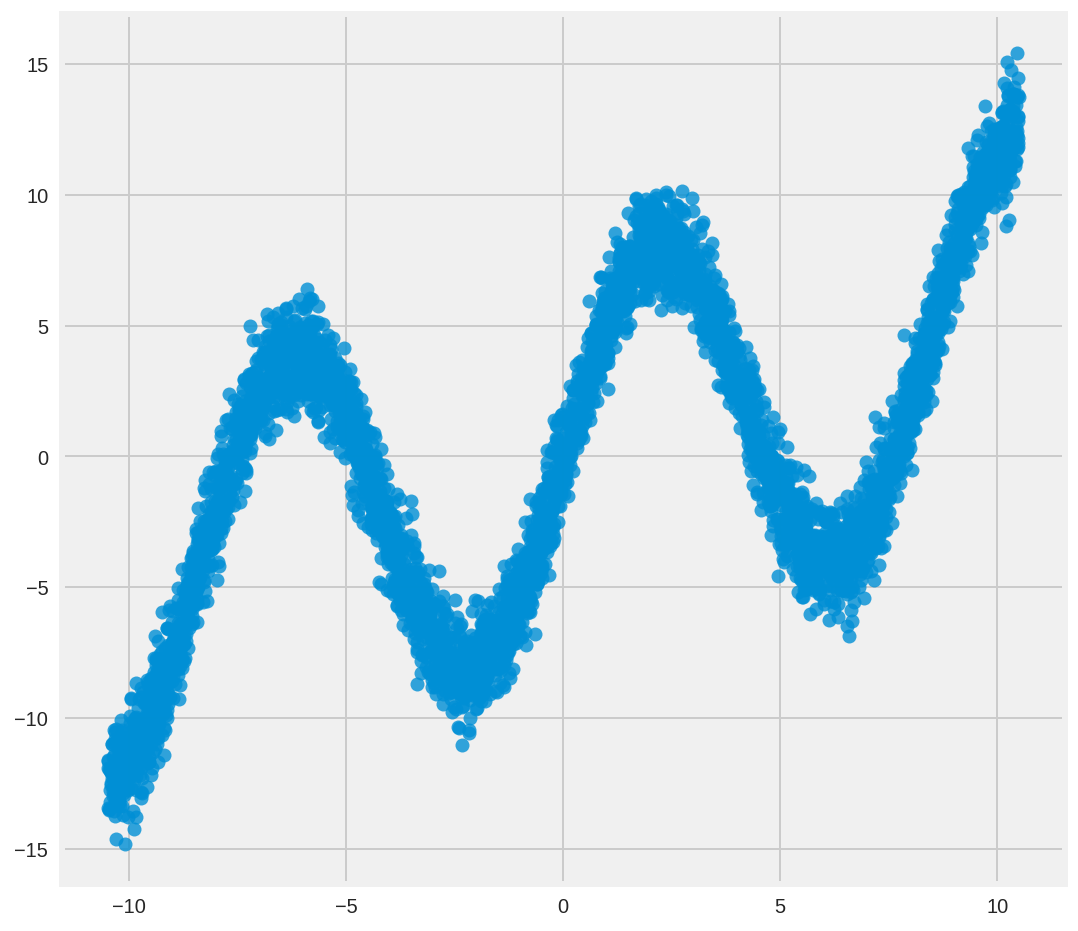

In [0]:
#@title Many-to-one Data features

# Set seed. Remove this line to generate different mixtures!
tf.set_random_seed(77)
#@markdown Number of data points
N = 5000  #@param {type:"number"} number of data points
#@markdown Number of features
D = 1     #@param {type:"number"} number of features
#@markdown Number of mixture components
K = 20    #@param {type:"number"} number of hidden components

x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, N))).T
r_data = np.float32(np.random.normal(size=(N, 1)))
y_data = np.float32(np.sin(0.75*x_data)*7.0+x_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
print("Size of features in x data: {}".format(x_data.shape))
print("Size of output in y data: {}".format(y_data.shape))
sns.regplot(x_data, y_data, fit_reg=False)
plt.show()

We can make a relatively simple predictive model for this one-to-many data. We will define our model as a simple neural network one-hidden layer and 20 nodes:

$$Y = W_\text{out}\text{tanh}(WX+b)+b_\text{out}$$

In [0]:
x = x_data
NHIDDEN = 20
W = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))
b = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))

W_out = tf.Variable(tf.random_normal([NHIDDEN,1], stddev=1.0, dtype=tf.float32))
b_out = tf.Variable(tf.random_normal([1,1], stddev=1.0, dtype=tf.float32))

hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)
y_out = tf.matmul(hidden_layer,W_out) + b_out

We can define a loss function as the sum of square error of the output vs the data (we can add regularisation if we want).

In [0]:
y = y_data
loss = tf.nn.l2_loss(y_out - y);

We will also define a training operator that will tell TensorFlow to minimise the loss function later. With just a line, we can use the fancy RMSProp gradient descent optimisation method.

In [0]:
train_op = tf.train.RMSPropOptimizer(learning_rate=0.1, decay=0.8).minimize(loss)

To start using TensorFlow to compute things, we have to define a session object. In an IPython shell, we use InteractiveSession. Afterwards, we need to run a command to initialise all variables, where the computation graph will also be built inside TensorFlow.

In [0]:
evaluate(tf.global_variables_initializer())

In [0]:
NEPOCH = 1000
for i in range(NEPOCH):
    evaluate(train_op)

We will run gradient descent for 1000 times to minimise the loss function with the data fed in via a dictionary. As the dataset is not large, we won’t use mini batches. After the below is run, the weight and bias parameters will be auto stored in their respective tf.Variable objects.

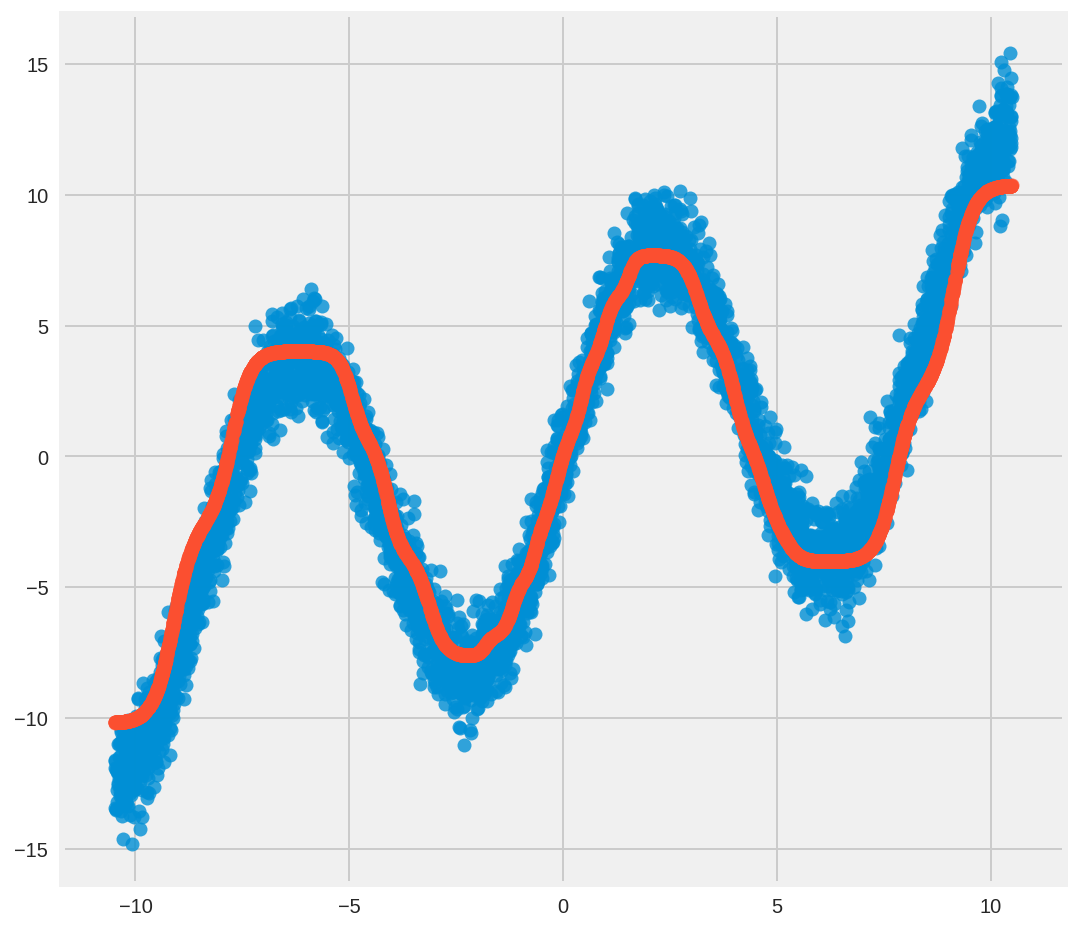

In [0]:
x_test = np.float32(np.random.uniform(-10.5, 10.5, (1, N))).T
x_test = x_test.reshape(x_test.size,1)
y_test = evaluate(y_out)

plt.figure(figsize=(8, 8))
sns.regplot(x_data, y_data, fit_reg=False)
sns.regplot(x_data, y_test, fit_reg=False)
plt.show()

We see that the neural network can fit this sinusoidal data quite well, as expected. However, this type of fitting method only works well when the function we want to approximate with the neural net is a one-to-one, or many-to-one function. Take for example, if we invert the training data:

$$
x = 7.0 \text{ sin}(0.75y) + 0.5y + \epsilon
$$

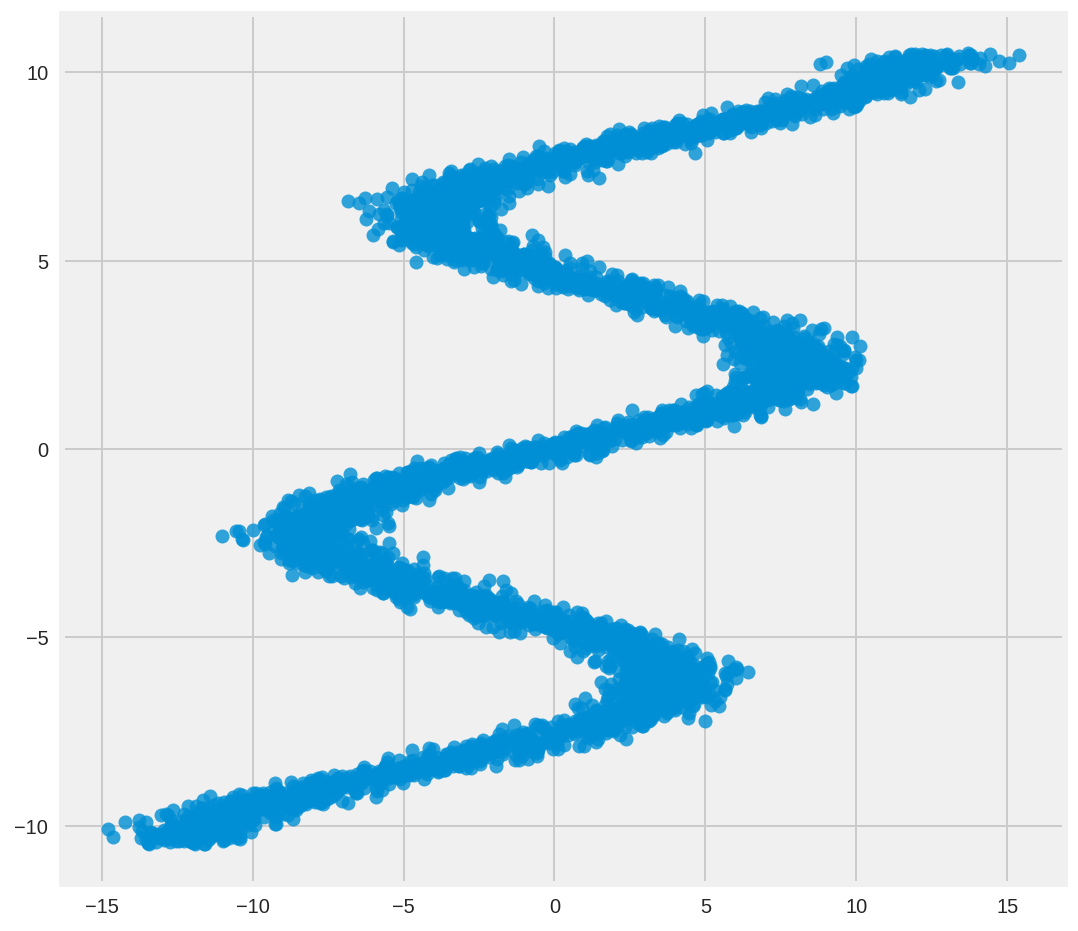

In [0]:
temp_data = x_data
x_data = y_data
y_data = temp_data

x = x_data
y = y_data

plt.figure(figsize=(8, 8))
sns.regplot(x_data,y_data, fit_reg=False)
plt.show()

If we were to use the same method to fit this inverted data, obviously it wouldn’t work well, and we would expect to see a neural network trained to fit only to the square mean of the data.

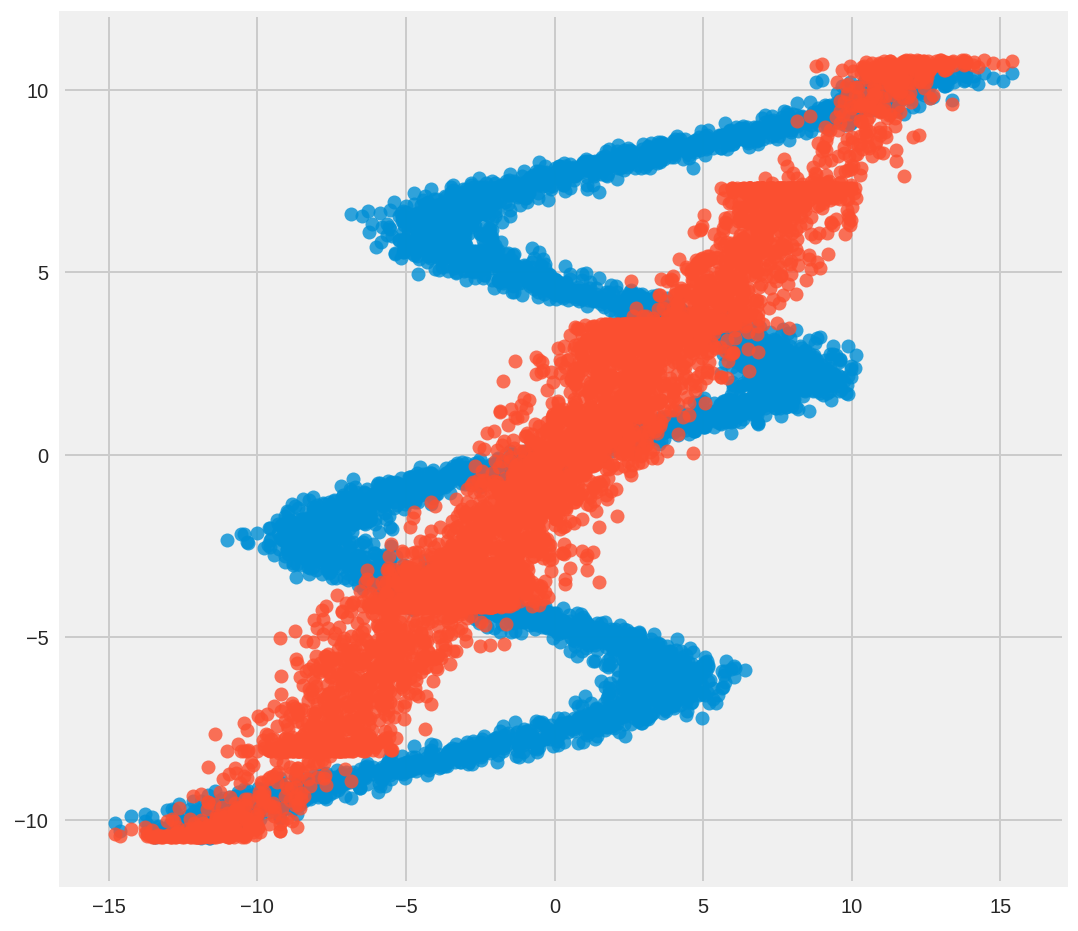

In [0]:
evaluate(tf.global_variables_initializer())

for i in range(NEPOCH):
    evaluate(train_op)

x_test = np.float32(np.random.uniform(-10.5, 10.5, (1, N))).T
x_test = x_test.reshape(x_test.size,1)
y_test = evaluate(y_out)

plt.figure(figsize=(8, 8))
sns.regplot(x_data, y_data, fit_reg=False)
sns.regplot(x_data, y_test, fit_reg=False)
plt.show()


Our current model only predicts one output value for each input, so this approach will fail miserably. What we want is a model that has the capacity to predict a range of different output values for each input. In the next section we will implement a Mixture Density Network (MDN) to do achieve this task.

## Mixture Density Networks (MDNs) to the rescue

Bishop’s implementation of MDNs will predict a class of probability distributions called Mixture Gaussian distributions, where the output value is modelled as a sum of many gaussian random values, each with different means and standard deviations. So for each input $x$, we will predict a probability distribution function (pdf) of $P(Y = y | X = x)$ that is a probability weighted sum of smaller gaussian probability distributions.

$$P(Y = y | X = x) = \sum_{k=0}^{K-1} \Pi_{k}(x) \phi(y, \mu_{k}(x), \sigma_{k}(x)), \sum_{k=0}^{K-1} \Pi_{k}(x) = 1 $$

Each of the parameters  $\Pi_{k}(x), \mu_{k}(x)$, $\sigma_{k}(x)$ of the distribution will be determined by the neural network, as a function of the input $x$. There is a restriction that the sum of  $\Pi_{k}(x)$ add up to one, to ensure that the pdf integrates to 100%. In addition, $\sigma_{k}(x)$ must be strictly positive.

In our implementation, we will use a neural network of one hidden later with $24$ nodes, and also generate $24$ mixtures, hence there will be $72$ actual outputs of our neural network of a single input. Our definition will be split into 2 parts:

$$
 Z = W_{o} \tanh( W_{h} X + b_{h}) + b_{o} 
$$

$Z$ is a vector of $72$ values that will be then splitup into three equal parts, $Z_{0\rightarrow23}$, $Z_{24\rightarrow43}$, and $Z_{44\rightarrow71}$

The parameters of the pdf will be defined as below to satisfy the earlier conditions:

$$
\Pi_{k} = \frac{\exp(Z_{k})}{\sum_{i=0}^{23} exp(Z_{i})} \\
\sigma = \exp(Z_{24\rightarrow43}) \\
\mu = Z_{44\rightarrow71}
$$

$\Pi_{k}$ are essentially put into a softmax operator to ensure that the sum adds to one, and that each mixture probability is positive. Each  $\sigma_{k}$ will also be positive due to the exponential operator. It gets deeper than this though! In Bishop’s paper, he notes that the softmax and exponential terms have some theoretical interpretations from a Bayesian framework way of looking at probability. Note that in the actual softmax code, the largest value will divide both numerator and denominator to avoid $\text{exp}$ operator easily blowing up.

Let's redefine our many-to-one function again (if you are running this in colab, you can toggle the number of data pionts, features, and mixture components)

$$
x = 7.0 \text{ sin}(0.75y) + 0.5y + \epsilon
$$

Notice that $x$ and $y$ are reversed. I.e., we're using a many-to-one function instead of a one-to-one function.

Size of features in data: (5000, 1)
Size of output in data: (5000,)


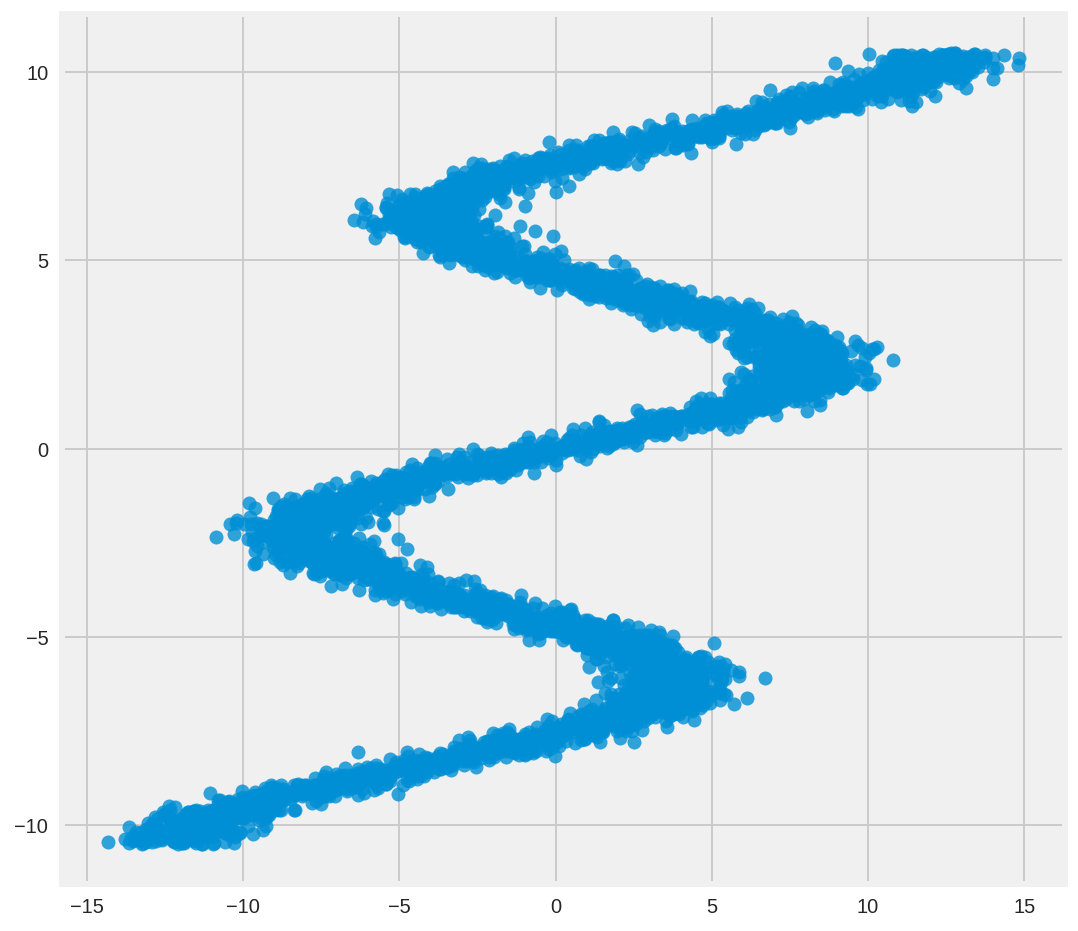

In [0]:
#@title Many-to-one Data features
def build_toy_dataset_inv(N):
    y_data = evaluate(tfd.Uniform(low=-10.5, high=10.5).sample(sample_shape=N))
    r_data = evaluate(tfd.Normal(loc=0., scale=1.).sample(sample_shape=N))  # random noise
    x_data = tf.math.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data_ = evaluate(tf.reshape(x_data, [N, 1]))
    return x_data_, y_data


# Set seed. Remove this line to generate different mixtures!
tf.set_random_seed(77)
#@markdown Number of data points
N = 5000  #@param {type:"number"} number of data points
#@markdown Number of features
D = 1     #@param {type:"number"} number of features
#@markdown Number of mixture components
K = 20    #@param {type:"number"} number of mixture components

x_data_, y_data_ = build_toy_dataset_inv(N)

print("Size of features in data: {}".format(x_data_.shape))
print("Size of output in data: {}".format(y_data_.shape))

plt.figure(figsize=(8, 8))
sns.regplot(x_data_, y_data_, fit_reg=False)
plt.show()

## Model

We use a mixture of 20 normal distributions parameterized by a
feedforward network. That is, the membership probabilities and
per-component mean and standard deviation are given by the output of a
feedforward network.

We use `tf.layers` to construct neural networks. We specify
a three-layer network with 15 hidden units for each hidden layer.

In [0]:
def neural_network(X):
    """
    loc, scale, logits = NN(x; theta)
    
    Args:
      X: Input Tensor containing input data for the MDN
    Returns:
      locs: The means of the normal distributions that our data is divided into.
      scales: The scales of the normal distributions that our data is divided 
        into.
      logits: The probabilities of ou categorical distribution that decides 
        which normal distribution our data points most probably belong to.
    """
    # 2 hidden layers with 15 hidden units
    net = tf.layers.dense(X, 15, activation=tf.nn.relu)
    net = tf.layers.dense(net, 15, activation=tf.nn.relu)
    locs = tf.layers.dense(net, K, activation=None)
    scales = tf.layers.dense(net, K, activation=tf.exp)
    logits = tf.layers.dense(net, K, activation=None)
    return locs, scales, logits


locs, scales, logits = neural_network(tf.convert_to_tensor(x_data_))
cat = tfd.Categorical(logits=logits)
components = [tfd.Normal(loc=loc, scale=scale) for loc, scale
              in zip(tf.unstack(tf.transpose(locs)),
                     tf.unstack(tf.transpose(scales)))]

y = tfd.Mixture(cat=cat, components=components)

Note that we use the `tfd.Mixture` distribution. It collapses out the membership assignments for each data point and makes the model differentiable with respect to all its parameters. It takes a `Categorical` random variable as input—denoting the probability for each cluster assignment—as well as `components`, which is a list of individual distributions to mix over.

For more background on MDNs, take a look at [Christopher Bonnett's blog post](http://cbonnett.github.io/MDN.html) or at Bishop (1994).

## Inference

We use Maximum A Posteriori (MAP) estimation, passing in the model and data set to an Adam Optimizer.

In [0]:
# There are no latent variables to infer. Thus inference is concerned
# with only training model parameters, which are baked into how we
# specify the neural networks.

log_likelihood = y.log_prob(y_data_)
log_likelihood = -tf.reduce_sum(log_likelihood)
learning_rate = 5e-2
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(log_likelihood)

Here, we will manually control the inference and how data is passed
into it at each step.
Initialize the algorithm and the TensorFlow variables.

In [0]:
evaluate(tf.global_variables_initializer())

Now we train the MDN by calling `evaluate([train_op, log_likelihood])`, passing in the data. The quantity `log_likelihood` is the loss function (negative log-likelihood) at that step of inference.  We keep track of the losses under `train_loss`.

In [0]:
n_epoch = 1000
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
    _, loss_value = evaluate([train_op, log_likelihood])
    train_loss[i] = loss_value

Note a common failure mode when training MDNs is that an individual mixture distribution collapses to a point. This forces the standard deviation of the normal to be close to `0` and produces `NaN` values. We can prevent this by thresholding the standard deviation if desired.

After training for a number of iterations, we get out the predictions we are interested in from the model: the predicted mixture weights, cluster means, and cluster standard deviations.

To do this, we fetch their values from session, feeding test data `X_test` to the placeholder `X_ph`.

In [0]:
pred_weights, pred_means, pred_std = evaluate([tf.nn.softmax(logits), locs, scales])

Let's plot the log-likelihood of the training and test data as
functions of the training epoch. The quantity `inference.loss`
is the total log-likelihood, not the loss per data point. Below we
plot the per-data point log-likelihood by dividing by the size of the
train and test data respectively.

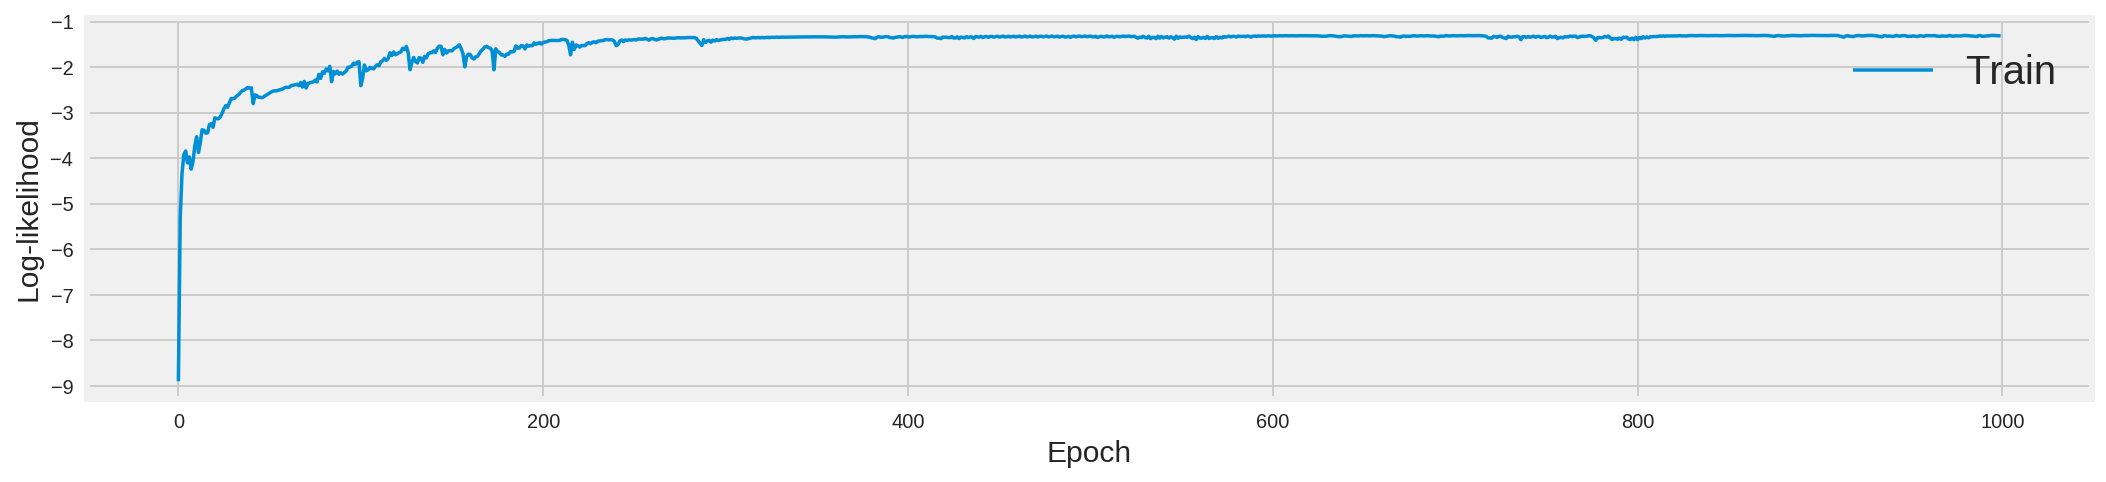

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(n_epoch), -train_loss / len(x_data_), label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Log-likelihood', fontsize=15)
plt.show()

We see that it converges after roughly 400 iterations.

## Criticism

Let's look at how individual examples perform. Note that as this is an inverse problem we can't get the answer correct, but we can hope that the truth lies in area where the model has high probability.

In this plot the truth is the vertical grey line while the blue line is the prediction of the mixture density network. As you can see, we didn't do too bad.

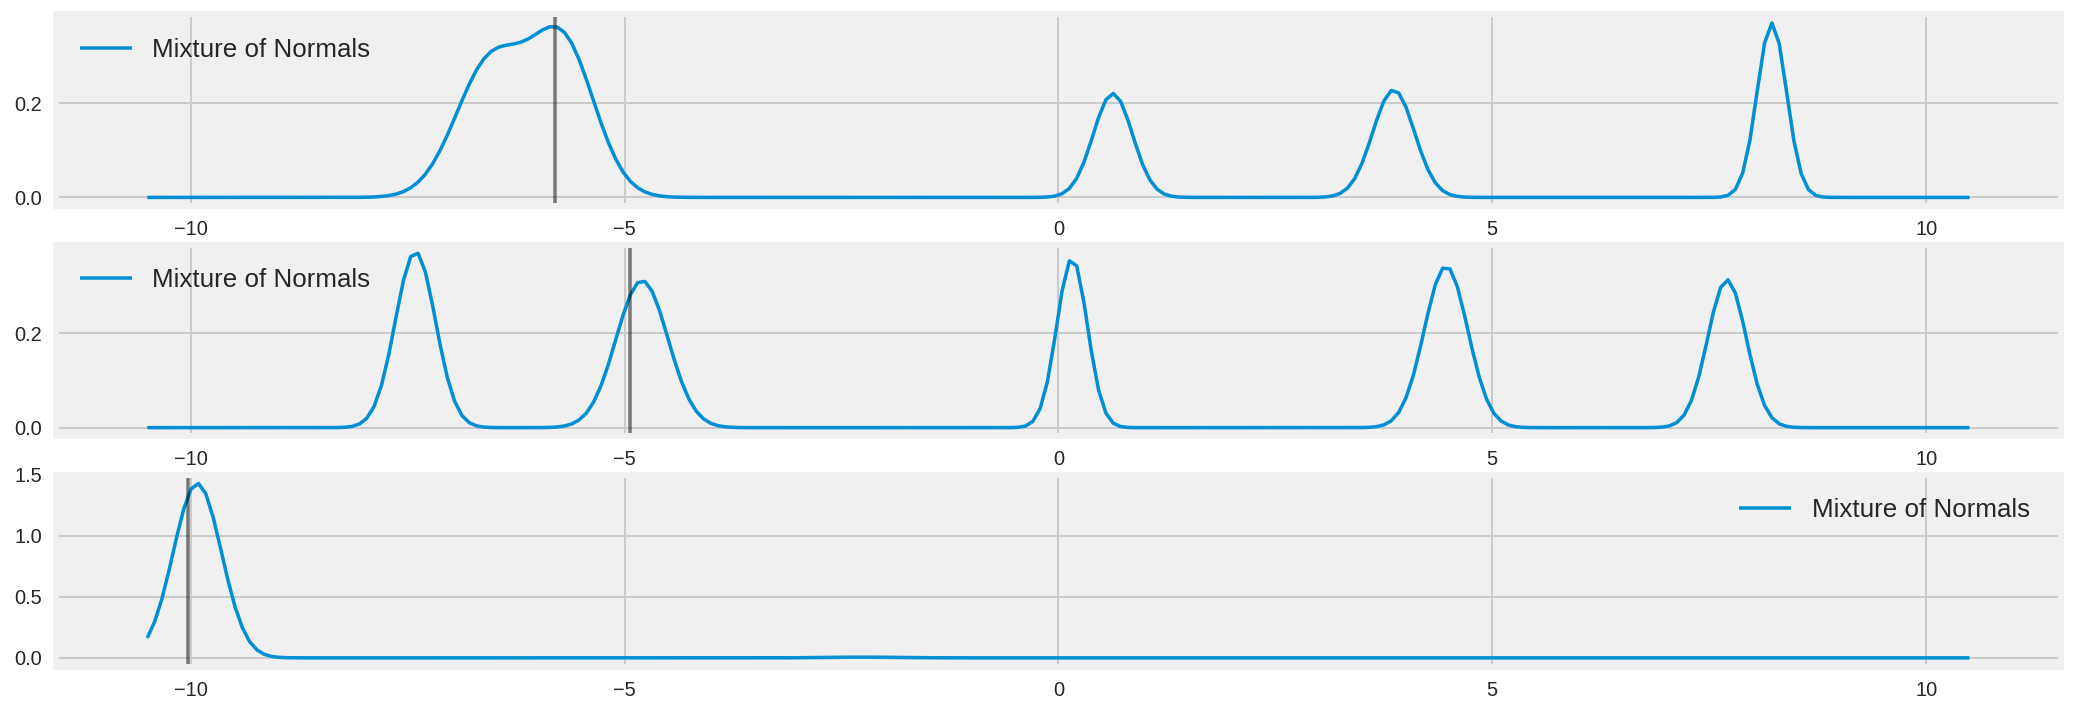

In [0]:
def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
    """Plots the mixture of Normal models to axis=ax comp=True plots all
    components of mixture model
    """
    x = np.linspace(-10.5, 10.5, 250)
    final = np.zeros_like(x)
    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
        temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
        final = final + temp
        if comp:
            ax.plot(x, temp, label='Normal ' + str(i))
    ax.plot(x, final, label='Mixture of Normals ' + label)
    ax.legend(fontsize=13)

obj = [0, 4, 6]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 6))

plot_normal_mix(pred_weights[obj][0], pred_means[obj][0],
                pred_std[obj][0], axes[0], comp=False)
axes[0].axvline(x=y_data_[obj][0], color='black', alpha=0.5)

plot_normal_mix(pred_weights[obj][2], pred_means[obj][2],
                pred_std[obj][2], axes[1], comp=False)
axes[1].axvline(x=y_data_[obj][2], color='black', alpha=0.5)

plot_normal_mix(pred_weights[obj][1], pred_means[obj][1],
                pred_std[obj][1], axes[2], comp=False)
axes[2].axvline(x=y_data_[obj][1], color='black', alpha=0.5)
plt.show()

We can check the ensemble by drawing samples of the prediction and
plotting the density of those. The MDN has learned what we'd like it
to learn.

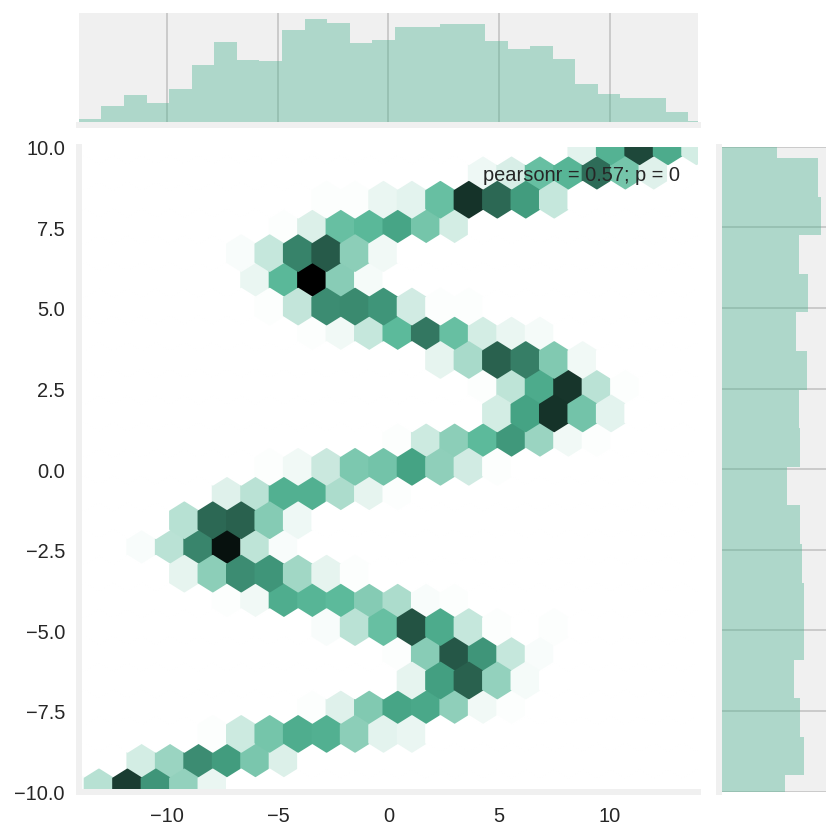

In [0]:
def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
    """
    Draws samples from mixture model.

    Returns 2 d array with input X and sample from prediction of mixture model.
    """
    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j, (weights, means, std_devs) in enumerate(
        zip(pred_weights, pred_means, pred_std)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j, 1] = np.random.normal(means[index], std_devs[index], size=1)
        samples[j, 0] = x[j]
        if j == amount - 1:
            break
    return samples

a = sample_from_mixture(x_data_, pred_weights, pred_means,
                        pred_std, amount=len(x_data_))
sns.jointplot(a[:, 0], a[:, 1], kind="hex", color="#4CB391",
              ylim=(-10, 10), xlim=(-14, 14))
plt.show()

## Conclusions

To reiterate, if what we are modelling has either multiple states, or is inherently a random variable that cannot be predicted with absolute certainty, then Mixture Density Networks can be a fantastic way to model that data. Even simple, single-layer MDNs can be upt to use, especially given that they are so simple to build. Not to mention they are easy to use given how fast TensorFlow's symbolic operation is.

## References
[1] Bishop, Christopher M. [Mixture density networks.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.120.5685&rep=rep1&type=pdf) Technical Report NCRG/4288, Aston University, Birmingham, UK, 1994.